# Database search with Grover's algorithm using Sampler primitive

In this tutorial, you will solve an unstructure search problem using Grover's algorithm with sampler primitive runtime program.

## 1. Set up local development environment

This tutorial requires IBM Runtime Service. If you haven't done so already, please follow the steps to set up your [Qiskit Runtime service instance](https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-quickstart).

## 2. Background information

### 2.1 Unstructured search problem

In the olden days, you can look up a person's phone number in a phone book. That is an easy task if you know the person's name because a phone book is orded alphabetically by the owner's name. However, the opposite task, that is you are given a phone number and want to find out who it belongs to, is much more difficult. That is because a phone book is not orded by phone numbers. This is an example of an unstructured search problem. To solve this problem with a classical computer, your best trick is to randomly pick an entry and on average you will need to look up half of the entires ($N/2$, if $N$ is the total number of entries) to find the owner. If you have a quantum computer, however, you can use Grover's algorithm to find the owner in $\sqrt N$ tries. That means to identify the owner in a phone book that has 1 million numbers, you only need to do 1000 tries instead of 500,000 tries!

### 2.2 Grover's algorithm

In a nutshell, Grover's algorithm uses a nice quantum trick called amplitude amplification to increase dramatically the chances of finding the correct answer - the owner of a phone number - in each try (iteration). That's all we need to know now. We don't have to understand the nitty-gritty of how Grover's algorithm works to apply it, because Qiskit does it for us! Of course you are welcome to read [the Qiskit textbook chapter](https://qiskit.org/textbook/ch-algorithms/grover.html) to learn the theory behind.

Let's look at a concrete example.

## 3. Create Grover's circuit

### 3.1 Define unstructured search problem in Qiskit

In this simple example, you are given a small phone book that has 8 entries, person 0 to person 7. And we want to find out the owner of a certain phone number. However, we are not allowed to look at the phone book directly. We are only allowed to consult an 'oracle': a black-box circuit that immediately tells us if our guess is right or wrong (like the Oracle in the Matrix movie).

In [1]:
import random
from qiskit.quantum_info import Statevector

secret = random.randint(0,7)  # the owner is randomly picked
secret_string = format(secret, '03b')  # format the owner in 3-bit string
oracle = Statevector.from_label(secret_string)  # let the oracle know the owner

Once we have the oracle, we can define the unstractured search problem using `AmplificationProblem` class in Qiskit. 

In [2]:
from qiskit.algorithms import AmplificationProblem

problem = AmplificationProblem(oracle, is_good_state=secret_string)

### 3.2 Construct Grover's circuit for the problem

Now we are ready to construct the quantum circuits for Grover's algorithm for this problem. Grover's algorithm's accuracy in finding the correct answer increases with the number of iterations. Let's create a circuit with 1 and 2 iterations to see the effect.

In [3]:
from qiskit.algorithms import Grover

grover_circuits = []
grover_circuits_decomposed = []
for iteration in range(1,3):
    grover = Grover(iterations=iteration)
    circuit = grover.construct_circuit(problem)
    circuit.measure_all()
    grover_circuits.append(circuit)
    # decompose circuits
    circuit_decomposed = circuit.decompose().decompose().decompose().decompose()
    grover_circuits_decomposed.append(circuit_decomposed)

Let's look at the circuits

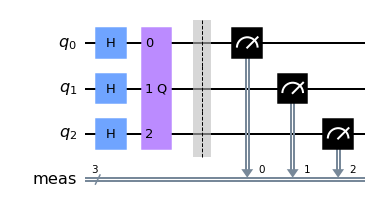

In [4]:
# With 1 iteration
grover_circuits[0].draw()

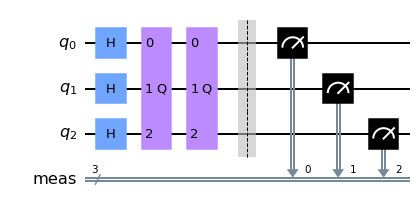

In [5]:
# With 2 iterations
grover_circuits[1].draw()

## 4. Submit circuits to IBM Cloud

Now that the Grover's circuits are created, let's submit them to IBM Cloud using the Sampler program.

### 4.1 Connect to IBM Runtime Service 

First connect to IBM Runtime Service as mentioned in [Step 1](#1.-Set-up-local-development-environment)

In [6]:
from qiskit_ibm_runtime import IBMRuntimeService

service = IBMRuntimeService()

Grover's algorithm determines the correct answer based on the highest probability of measurement outcome. The Sampler program is perfect for getting probabilities, so we will use that.

In [7]:
from qiskit_ibm_runtime import IBMSampler

sampler_factory = IBMSampler(service=service)

with sampler_factory(circuits=grover_circuits_decomposed) as sampler:
    result = sampler(circuit_indices=[0,1], shots=1000)
    print(result)

SamplerResult(quasi_dists=[{'010': 0.019, '101': 0.033, '001': 0.027, '100': 0.762, '110': 0.043, '000': 0.043, '011': 0.028, '111': 0.045}, {'010': 0.008, '001': 0.006, '101': 0.011, '100': 0.934, '110': 0.011, '011': 0.007, '111': 0.012, '000': 0.011}], metadata=[{'header_metadata': None, 'shots': 1000}, {'header_metadata': None, 'shots': 1000}])


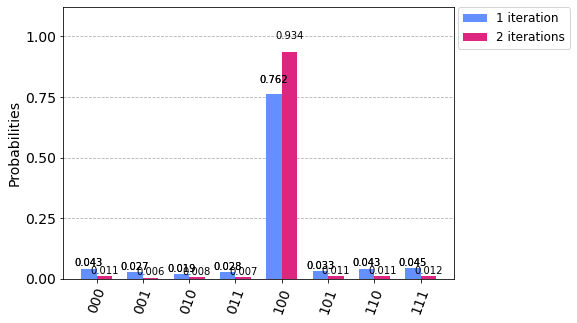

In [8]:
# Let's look at the results
from qiskit.tools.visualization import plot_histogram
plot_histogram(result.quasi_dists, legend=['1 iteration', '2 iterations'])

In [9]:
# As you can see, "110"
# Did the quantum computer find the correct answer? Let's now reveal our secret string. 
d = result.quasi_dists[1]
highest_prob = max(d, key=d.get)
print(f"Quantum answer: {highest_prob}")
print(f"Correct answer: {secret_string}")
print('Success!' if highest_prob == secret_string else 'Failure!')

Quantum answer: 100
Correct answer: 100
Success!


You can re-run the tutorials a few times to generate other random secret strings to see that we are not cheating! The quantum computer finds the correct answer every time.

In [10]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.2.0'

In [11]:
from qiskit.tools.jupyter import *

%qiskit_version_table
%qiskit_copyright